In [1]:
from fastai.vision.all import *

In [2]:
DATASETS_DIR = Path(os.environ['DATASETS_DIR'])/'sorghum-id-fgvc-9'
DATASETS_DIR.ls()

(#4) [Path('/datasets/sorghum-id-fgvc-9/train_cultivar_mapping.csv'),Path('/datasets/sorghum-id-fgvc-9/test'),Path('/datasets/sorghum-id-fgvc-9/train_images'),Path('/datasets/sorghum-id-fgvc-9/sample_submission.csv')]

In [3]:
(DATASETS_DIR/'train_images').ls()

(#22194) [Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-19__13-06-29-651.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-03__12-58-24-135.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-15__12-32-43-241.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-01__11-31-50-488.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-02__16-25-06-191.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-28__12-52-56-384.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-05__12-08-56-198.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-13__11-37-46-365.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-26__18-27-33-812.png'),Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-27__11-00-20-408.png')...]

In [4]:
(DATASETS_DIR/'test').ls()

(#23639) [Path('/datasets/sorghum-id-fgvc-9/test/1320211956.png'),Path('/datasets/sorghum-id-fgvc-9/test/1460752465.png'),Path('/datasets/sorghum-id-fgvc-9/test/1437601570.png'),Path('/datasets/sorghum-id-fgvc-9/test/1053653999.png'),Path('/datasets/sorghum-id-fgvc-9/test/937061344.png'),Path('/datasets/sorghum-id-fgvc-9/test/1526324826.png'),Path('/datasets/sorghum-id-fgvc-9/test/1295561477.png'),Path('/datasets/sorghum-id-fgvc-9/test/993820791.png'),Path('/datasets/sorghum-id-fgvc-9/test/1054144892.png'),Path('/datasets/sorghum-id-fgvc-9/test/1911037980.png')...]

In [5]:
pd.read_csv(DATASETS_DIR/'train_cultivar_mapping.csv').head()

,image,cultivar
0,2017-06-16__12-24-20-930.png,PI_257599
1,2017-06-02__16-48-57-866.png,PI_154987
2,2017-06-12__13-18-07-707.png,PI_92270
3,2017-06-22__13-18-06-841.png,PI_152651
4,2017-06-26__12-56-48-642.png,PI_176766


In [6]:
pd.read_csv(DATASETS_DIR/'sample_submission.csv').head()

,filename,cultivar
0,1000005362.png,PI_152923
1,1000099707.png,PI_152923
2,1000135300.png,PI_152923
3,1000136796.png,PI_152923
4,1000292439.png,PI_152923


In [7]:
files = get_image_files(DATASETS_DIR/"train_images")
len(files)

22193

In [8]:
files[0]

Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-19__13-06-29-651.png')

In [9]:
df = pd.read_csv(DATASETS_DIR/'train_cultivar_mapping.csv')
df.head()

,image,cultivar
0,2017-06-16__12-24-20-930.png,PI_257599
1,2017-06-02__16-48-57-866.png,PI_154987
2,2017-06-12__13-18-07-707.png,PI_92270
3,2017-06-22__13-18-06-841.png,PI_152651
4,2017-06-26__12-56-48-642.png,PI_176766


In [10]:
df_dict = df.set_index('image').to_dict()['cultivar']
df_dict['2017-06-16__12-24-20-930.png']

'PI_257599'

In [11]:
imgs = get_image_files(DATASETS_DIR/'train_images')

In [12]:
imgs[0]

Path('/datasets/sorghum-id-fgvc-9/train_images/2017-06-19__13-06-29-651.png')

In [13]:
def get_cultivar(img_path):
    return df_dict[img_path.name]

In [14]:
get_cultivar(imgs[0])

'PI_146890'

In [15]:
MODEL = resnet50
BS = 8*7
RESIZE_TO = 32*20
ITEM_TFMS = RandomResizedCrop(RESIZE_TO)
BATCH_TFMS = aug_transforms()
METRICS = error_rate

In [16]:
def get_dls(path, bs, item_resize, batch_resize, batch_min_scale):
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=get_cultivar,
        item_tfms=Resize(item_resize),
        batch_tfms=[*aug_transforms(size=batch_resize, min_scale=batch_min_scale),
                    Normalize(),#.from_stats(*imagenet_stats)
                   ])
    return dblock.dataloaders(path, bs=bs)

In [17]:
dls = get_dls(
    path=(DATASETS_DIR/'train_images'), 
    bs=64, 
    item_resize=460,
    batch_resize=224,
    batch_min_scale=0.75,
)

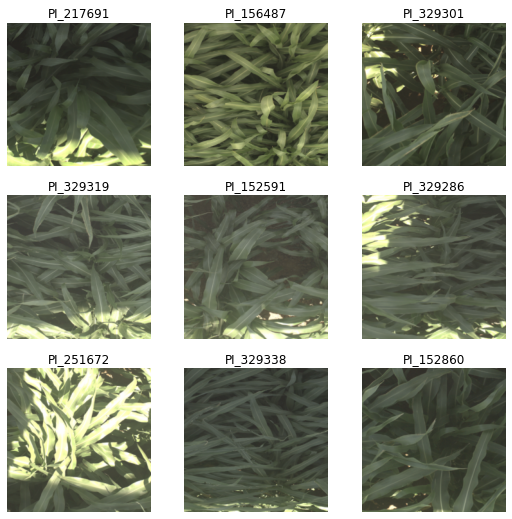

In [18]:
dls.show_batch()

In [19]:
x, y = dls.one_batch()

In [20]:
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([0.0949, 0.0932, 0.1116], device='cuda:0'),
 TensorImage([0.9727, 0.9727, 0.9897], device='cuda:0'))

In [21]:
xresnet50()[-1]

Linear(in_features=2048, out_features=1000, bias=True)

In [22]:
xresnet50(n_out=20)[-1]

Linear(in_features=2048, out_features=20, bias=True)

In [23]:
model = xresnet50(n_out=dls.c)

In [24]:
dls = get_dls(
    path=(DATASETS_DIR/'train_images'), 
    bs=128, 
    item_resize=460,
    batch_resize=128,
    batch_min_scale=0.75,
)

In [25]:
learn = Learner(
    dls,
    model,
    loss_func=CrossEntropyLossFlat(),
    metrics=error_rate
)

SuggestedLRs(valley=7.585775892948732e-05)

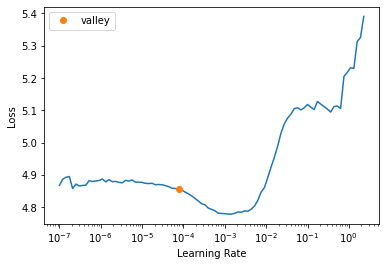

In [26]:
learn.lr_find()

In [27]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,4.553156,4.445910,0.957413,03:23
1,4.220466,4.142747,0.925642,03:23
2,3.964590,3.890455,0.890942,03:24
3,3.806300,3.781210,0.874944,03:24
4,3.734868,3.747006,0.866832,03:23


In [28]:
learn.fit_one_cycle(5, 2e-4)

epoch,train_loss,valid_loss,error_rate,time
0,3.708441,3.927347,0.898378,03:23
1,3.465242,3.548522,0.851059,03:24
2,3.184677,3.107105,0.776025,03:23
3,2.986304,2.974103,0.737269,03:23
4,2.872398,2.949351,0.735241,03:24


In [29]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,2.863121,2.858706,0.715863,03:24
1,2.848758,2.890396,0.731861,03:24
2,2.806468,2.737290,0.698288,03:23
3,2.696379,2.716945,0.694457,03:22
4,2.598743,2.724011,0.700315,03:23
5,2.494424,2.563770,0.662911,03:22
6,2.411902,2.544834,0.664714,03:24
7,2.349272,2.436140,0.636323,03:23
8,2.310701,2.534606,0.661559,03:28
9,2.282275,2.414638,0.626634,03:23


SuggestedLRs(valley=2.0892961401841603e-05)

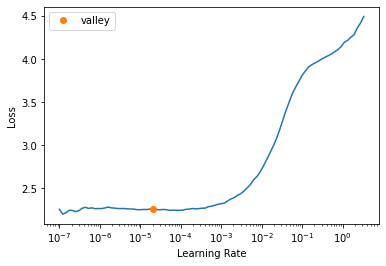

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(10, 2e-5)

epoch,train_loss,valid_loss,error_rate,time
0,2.288800,2.499470,0.649392,03:27
1,2.294607,2.377985,0.619423,03:25
2,2.294523,2.439692,0.639477,03:25
3,2.278476,2.376852,0.627310,03:25
4,2.258809,2.423882,0.640379,03:24
5,2.216194,2.317317,0.611311,03:24
6,2.200758,2.378343,0.630014,03:25
7,2.191507,2.325179,0.614917,03:24
8,2.181848,2.334092,0.615367,03:24
9,2.184521,2.337189,0.618973,03:24


In [ ]:
learn.fit_one_cycle(50, lr_max=slice(5e-4, 3e-3))

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=slice(1e-6, 5e-6))

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=slice(2e-5, 2e-4))

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, lr_max=slice(5e-5, 3e-4))

In [ ]:
learn.save()

In [ ]:
learn.save("resnet50_e012618")

In [ ]:
test_files = get_image_files(DATASETS_DIR/"test")
len(test_files)

In [ ]:
test_dl = learn.dls.test_dl(test_files)

In [ ]:
test_files

In [ ]:
tta_preds, _ = learn.tta(dl=test_dl, n=10)

In [ ]:
decoded = tta_preds.argmax(dim=1)

In [ ]:
learn.dls.vocab[decoded]

In [ ]:
fieldnames = ['filename', 'cultivar']
predictions = [{'filename': f.name, 'cultivar': c} 
               for f,c in zip(test_files, learn.dls.vocab[decoded])]

In [ ]:
import csv
  
with open('predictions.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
    writer.writeheader()
    writer.writerows(predictions)